# Argo Data Loading Workflow

## Imports

In [24]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import argopy
from pathlib import Path
from argopy import DataFetcher as ArgoDataFetcher
from dask.diagnostics import ProgressBar
import dask
argo_loader = ArgoDataFetcher(src="gdac", ftp="/swot/SUM05/dbalwada/Argo_sync", progress=False)

I've synced a local copy of the entire Argo dataset that lives in the directory `/swot/SUM05/dbalwada/Argo_sync`. Instructions for how to do this can be found here: http://www.argodatamgt.org/Access-to-data/Argo-GDAC-synchronization-service

It's also possible to download from a remote server directly (like using `src="erddap"`), however I've found this to be inefficient and error-prone for large regions.

# Load Small Box (~5deg x 5deg)

This function loads the Argo data in a given lat/lon range and returns it as one dataset, interpolated to a common pressure grid. This is suitable for fairly small regions (a few degrees each direction).

### Load Box

In [9]:
box = [-30,-25,0,5,0,2000]
ds_box = prf.get_box(box)

loading points complete
USING LOCAL ARGOPY DIRECTORY
to xarray complete
point to profile complete
NEW INTERP FUNCTION
	Profile 2227 has invalid depth range: depth_min=0.0, depth_max=0
	Profile 2243 has invalid depth range: depth_min=0.0, depth_max=0
	Profile 2314 has invalid depth range: depth_min=0.0, depth_max=0
interpolation complete
adding spice complete


In [10]:
ds_box

<xarray.Dataset> Size: 115MB
Dimensions:            (PRES_INTERPOLATED: 1001, N_PROF: 2397)
Coordinates:
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 8kB 0 2 4 6 ... 1996 1998 2000
  * N_PROF             (N_PROF) int64 19kB 893 894 892 888 ... 1486 827 806 851
    TIME               (N_PROF) datetime64[ns] 19kB 2000-08-29T07:36:13 ... 2...
    LATITUDE           (N_PROF) float64 19kB 4.25 3.828 4.694 ... 4.184 4.102
    LONGITUDE          (N_PROF) float64 19kB -29.69 -29.24 ... -29.51 -27.88
Data variables:
    CT                 (N_PROF, PRES_INTERPOLATED) float64 19MB nan nan ... nan
    CYCLE_NUMBER       (N_PROF) int64 19kB 16 21 19 21 22 ... 140 138 138 138
    DATA_MODE          (N_PROF) <U1 10kB 'D' 'D' 'D' 'D' 'D' ... 'R' 'R' 'R' 'R'
    DIRECTION          (N_PROF) <U1 10kB 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER    (N_PROF) int64 19kB 3900133 3900133 ... 1902305 1902391
    PRES               (N_PROF, PRES_INTERPOLATED) float32 10MB nan nan ... nan
    PSAL               (N_PROF, PRES_INTERPOLATED) float32 10MB nan nan ... nan
    SA                 (N_PROF, PRES_INTERPOLATED) float64 19MB nan nan ... nan
    SIG0               (N_PROF, PRES_INTERPOLATED) float64 19MB nan nan ... nan
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 10MB nan nan ... nan
    sample_rate        (N_PROF, PRES_INTERPOLATED) float32 10MB nan nan ... nan
    SPICE              (N_PROF, PRES_INTERPOLATED) float64 19MB nan nan ... nan
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/08/21
    Fetched_constraints:  [x=-30.00/-25.00; y=0.00/5.00; z=0.0/2000.0]
    Fetched_uri:          https://data-argo.ifremer.fr/dac/aoml/1901468/19014...
    Valid uris:           ['https://data-argo.ifremer.fr/dac/aoml/1901468/190...
    All uris:             ['https://data-argo.ifremer.fr/dac/aoml/1901468/190...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

# Load Large Region (~entire basin)

This function loads the Argo data in a much larger lat/long range and saves the data into small boxes, at a filepath specified in the `get_box_delayed` function. After this is complete, look to the concat section below to concatonate the individual xr ds for each box into one ds for the whole reigon.

This workflow parallelizes the loading process by taking one large region and dividing it into subregions, and dividing each subregion into boxes. It iterates through subregions, taking one at a time and dividing it into boxes. Each box is then passed to one core, which loads all argo files in the given lat/lon range (using the `get_box` function from above), and saving the data as an xr ds in a netcdf file. The boxes are loaded in parallel using dask. Once one subregion is completed, it moves onto the next and repeates these steps until the whole region has been complete.

It make take some thought and practice to pick the `region_step` and `box_step` intervals to match the resouces available to your machine. For example, for efficiency, the number of boxes in each region should be slightly lower than the number of available cores. For a system with 72 cores, I would plan to have ~60 boxes in each subregion. It would also be ideal to make sure the number of boxes in each subregion is less than the number of workers initialized in the dask cluster.

### Initialize Dask Cluster

The number of workers, threads, and memory can be changed to correspond to a given machine. Or remove them to use default settings.

In [2]:
import os
import sys
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
sys.path.append(os.path.abspath('../funcs'))

import processing_funcs as prf

In [3]:
import dask
from dask.distributed import Client, LocalCluster

# Create a LocalCluster
cluster = LocalCluster(n_workers=32, threads_per_worker=2, memory_limit='30GiB')

# Connect to the cluster
client = Client(cluster)

# Print the cluster information
print(cluster)

/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34690 instead
  warnings.warn(


LocalCluster(e4f39ab1, 'tcp://127.0.0.1:44524', workers=32, threads=64, memory=0.94 TiB)


### Functions

In [4]:
@dask.delayed
def get_box_delayed(*args, **kwargs):
    """
    Wraps `get_box` in a Dask-delayed task with exception handling.

    Parameters
    ----------
    *args, **kwargs : 
        Arguments passed directly to `get_box`.

    Returns
    -------
    xarray.Dataset or tuple
        Returns the result of `get_box` if successful.
        If an exception occurs, returns a tuple of (error_type, error_message).
    
    Notes
    -----
    This function is designed for use in parallelized workflows where 
    failure of individual tasks should not halt execution. It enables 
    robust error tracking during batch processing.
    """
    
    try:
        return prf.get_box(*args, **kwargs)
    except Exception as e:
        return type(e).__name__, str(e)

In [5]:
def get_box_dask(boxes_list):
    """
    Executes `get_box_delayed` across a list of bounding boxes using Dask.

    Parameters
    ----------
    boxes_list : list of tuples
        Each tuple should contain four floats: (lon_min, lon_max, lat_min, lat_max).
        These define the spatial extent of each box to be processed.

    Returns
    -------
    errors : list of lists
        Each sublist contains [lon_min, lon_max, lat_min, lat_max, error_type, error_message]
        for boxes that failed during processing.

    Side Effects
    ------------
    - Saves each successfully retrieved dataset to NetCDF using a filename 
      that encodes the bounding box coordinates.
    - Prints progress updates and error diagnostics to stdout.

    Notes
    -----
    - Each box is wrapped in a singleton tuple to match the expected input format.
    - Errors are caught and logged without interrupting the batch run.
    - Output filenames follow the pattern:
      `lon:(lon_min,lon_max)_lat:(lat_min,lat_max)_ds_z.nc`
    - This function assumes `get_box` returns an xarray.Dataset with a `.to_netcdf()` method.
    """
    
    boxes_list = [tuple([box]) for box in boxes_list]
    
    # Create a list of delayed tasks
    tasks = [get_box_delayed(*args) for args in boxes_list]

    # Compute the results in parallel
    results = dask.compute(*tasks)
    
    errors=[]

    # Process the results as needed
    for n, result in enumerate(results):
        if isinstance(result, tuple) and isinstance(result[0], str):
            error_type, error_message = result
            print("Error in box {}: {} - {}".format([boxes_list[n][0][0],boxes_list[n][0][1],boxes_list[n][0][2],boxes_list[n][0][3]], error_type, error_message))
            errors.append([boxes_list[n][0][0],boxes_list[n][0][1],boxes_list[n][0][2],boxes_list[n][0][3], error_type, error_message])
        else:
            result.to_netcdf("/swot/SUM05/amf2288/sync-boxes/workflow_test/lon:({},{})_lat:({},{})_ds_z.nc".format(boxes_list[n][0][0],boxes_list[n][0][1],boxes_list[n][0][2],boxes_list[n][0][3]))
            print("Saved box {} of {}".format(n+1, len(results)))
            
    return errors 

In [6]:
def generate_grid(box, step):
    """
    Subdivides a region into smaller spatial boxes of uniform size.

    Parameters
    ----------
    box : list of float
        Bounding box in the format [lon_min, lon_max, lat_min, lat_max, z_min, z_max].
        Defines the spatial and vertical extent of the region to be subdivided.
    
    step : float
        Size of each sub-box in degrees (applied to both latitude and longitude).

    Returns
    -------
    grid : list of lists
        List of sub-boxes, each in the format [lat_min, lat_max, lon_min, lon_max, z_min, z_max].

    Notes
    -----
    - Latitude and longitude are incremented in nested loops to tile the full region.
    - Edge boxes are truncated to avoid exceeding the original bounds.
    - Vertical bounds (z_min, z_max) are preserved across all sub-boxes.
    """

    grid = []
    lon_min, lon_max, lat_min, lat_max = box[0],box[1],box[2],box[3]
    lat = lat_min
    while lat < lat_max:
        lon = lon_min
        while lon < lon_max:
            # Ensure the box does not exceed the specified bounds
            box_lat_max = min(lat + step, lat_max)
            box_lon_max = min(lon + step, lon_max)
            box = [lat, box_lat_max, lon, box_lon_max, box[4], box[5]]
            grid.append(box)
            lon += step
        lat += step
    return grid

In [7]:
def get_region(area, region_step, box_step):
    """
    Loads Argo data for a large region by subdividing into subregions, where individual
    boxes are processed in parallel. Saves the outputs of each box as individual netcdf files.

    Parameters
    ----------
    area : list of float
        Bounding box in the format [lon_min, lon_max, lat_min, lat_max, z_min, z_max].
        Defines the full spatial and vertical extent of the region to be processed.
    
    region_step : int
        Size of each subregion in degrees. Used to subdivide `area` into regions.
    
    box_step : int
        Size of each box within a subregion.

    Returns
    -------
    errors_list : list of lists
        Each sublist contains errors returned by `get_box_dask` for a given region.
        Errors are formatted as [lon_min, lon_max, lat_min, lat_max, error_type, error_message].

    Side Effects
    ------------
    - Prints detailed progress updates for each region and its constituent boxes.
    - Calls `get_box_dask` to process each box and collect error diagnostics.

    Notes
    -----
    - Uses `generate_grid` twice: first to tile the full area into subregions,
      then to tile each region into boxes.
    - Assumes `get_box_dask` handles parallel execution and error handling.
    - Variable `cluster` is referenced but not defined in this scope—may need to be passed in or removed.
    """
    
    regions = generate_grid(area, region_step)
    print('-' * 50)
    print("Cluster: {}".format(cluster))
    print('-' * 50)
    print("THE REGIONS ARE {}".format(regions))
    print('-' * 50)
    
    errors_list = []
    
    for n,region in enumerate(regions):
        boxes = generate_grid(region, box_step)
        print('-' * 50)
        print("REGION #{} OUT OF {} IS: {}".format(n+1, len(regions), region))
        print('-' * 50)
        print("THE BOXES IN REGION #{} ARE {}".format(n+1,boxes))
        print('-' * 50)

        errors = get_box_dask(boxes)
        errors_list.append([errors])
        
        print('-' * 50)
        print("COMPLETED REGION #{} OUT OF {}".format(n+1,len(regions)))
        print('-' * 50)
        
    return errors_list

### Load region

In [8]:
s_atl = [-55,-15,-90,-10,0,2000]
region_step = 40
box_step = 5
get_region(s_atl, region_step, box_step)

--------------------------------------------------
Cluster: LocalCluster(e4f39ab1, 'tcp://127.0.0.1:44524', workers=32, threads=64, memory=0.94 TiB)
--------------------------------------------------
THE REGIONS ARE [[-90, -50, -55, -15, 0, 2000], [-50, -10, -55, -15, 0, 2000]]
--------------------------------------------------
--------------------------------------------------
REGION #1 OUT OF 2 IS: [-90, -50, -55, -15, 0, 2000]
--------------------------------------------------
THE BOXES IN REGION #1 ARE [[-55, -50, -90, -85, 0, 2000], [-55, -50, -85, -80, 0, 2000], [-55, -50, -80, -75, 0, 2000], [-55, -50, -75, -70, 0, 2000], [-55, -50, -70, -65, 0, 2000], [-55, -50, -65, -60, 0, 2000], [-55, -50, -60, -55, 0, 2000], [-55, -50, -55, -50, 0, 2000], [-50, -45, -90, -85, 0, 2000], [-50, -45, -85, -80, 0, 2000], [-50, -45, -80, -75, 0, 2000], [-50, -45, -75, -70, 0, 2000], [-50, -45, -70, -65, 0, 2000], [-50, -45, -65, -60, 0, 2000], [-50, -45, -60, -55, 0, 2000], [-50, -45, -55, -50, 0

/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:497: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:497: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:497: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:497: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:497: RuntimeWarning: divide 

Error in box [-55, -50, -90, -85]: FSTimeoutError - 
Error in box [-55, -50, -85, -80]: DataNotFound - 'No data found for: x=-55.00/-50.00;y=-85.00/-80.00'
Error in box [-55, -50, -80, -75]: FSTimeoutError - 
Error in box [-55, -50, -75, -70]: FSTimeoutError - 
Error in box [-55, -50, -70, -65]: FSTimeoutError - 
Error in box [-55, -50, -65, -60]: ValueError - This is not a Argo GDAC compliant file path (invalid DAC name: 'kiost')
Error in box [-55, -50, -60, -55]: ValueError - This is not a Argo GDAC compliant file path (invalid DAC name: 'kiost')
Error in box [-55, -50, -55, -50]: ValueError - This is not a Argo GDAC compliant file path (invalid DAC name: 'kiost')
Error in box [-50, -45, -90, -85]: DataNotFound - 'No data found for: x=-50.00/-45.00;y=-90.00/-85.00'
Error in box [-50, -45, -85, -80]: DataNotFound - 'No data found for: x=-50.00/-45.00;y=-85.00/-80.00'
Error in box [-50, -45, -80, -75]: FSTimeoutError - 
Saved box 12 of 64
Saved box 13 of 64
Error in box [-50, -45, -65,

[[[[-55, -50, -90, -85, 'FSTimeoutError', ''],
   [-55,
    -50,
    -85,
    -80,
    'DataNotFound',
    "'No data found for: x=-55.00/-50.00;y=-85.00/-80.00'"],
   [-55, -50, -80, -75, 'FSTimeoutError', ''],
   [-55, -50, -75, -70, 'FSTimeoutError', ''],
   [-55, -50, -70, -65, 'FSTimeoutError', ''],
   [-55,
    -50,
    -65,
    -60,
    'ValueError',
    "This is not a Argo GDAC compliant file path (invalid DAC name: 'kiost')"],
   [-55,
    -50,
    -60,
    -55,
    'ValueError',
    "This is not a Argo GDAC compliant file path (invalid DAC name: 'kiost')"],
   [-55,
    -50,
    -55,
    -50,
    'ValueError',
    "This is not a Argo GDAC compliant file path (invalid DAC name: 'kiost')"],
   [-50,
    -45,
    -90,
    -85,
    'DataNotFound',
    "'No data found for: x=-50.00/-45.00;y=-90.00/-85.00'"],
   [-50,
    -45,
    -85,
    -80,
    'DataNotFound',
    "'No data found for: x=-50.00/-45.00;y=-85.00/-80.00'"],
   [-50, -45, -80, -75, 'FSTimeoutError', ''],
   [-50, -45

# Concat Region

This takes the individual boxes saved by the `get_region` function and concatonates them into one file, which is then saved. There are two functions, with the choice of saving the output as a netcdf file or as a zarr store. Once this is complete (and you've checked it has worked properly), probably good to delete the directory with individual netcdf files.

### Functions

In [11]:
def concatenate_netcdf(input_dir: str, first_dim: str, second_dim: str, output_dir: str, output_file: str):
    """
    Concatenates multiple NetCDF files along a specified dimension and saves the result to disk.

    Parameters
    ----------
    input_dir : str
        Directory containing NetCDF files to be concatenated.
    
    first_dim : str
        Name of the dimension along which datasets will be concatenated (e.g., 'N_PROF').
    
    second_dim : str
        Secondary dimension used for chunking (e.g., 'PRES_INTERPOLATED').
    
    output_dir : str
        Directory where the concatenated NetCDF file will be saved.
    
    output_file : str
        Name of the output NetCDF file.

    Returns
    -------
    None

    Notes
    -----
    - Uses Dask to lazily open and concatenate datasets for scalability.
    - Rechunks the combined dataset to ensure uniform chunk sizes for efficient I/O.
    - Automatically creates the output directory if it doesn't exist.
    - Prints progress via a Dask `ProgressBar` during file write.
    - Assumes all input files share compatible dimensions and metadata.
    """

    input_path = Path(input_dir)
    netcdf_files = list(input_path.glob("*.nc"))
    
    # Create the output directory if it doesn't exist
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Open datasets lazily with dask
    datasets = [xr.open_dataset(str(file), chunks={}) for file in netcdf_files]
    
    # Concatenate along the first dimension
    combined_first_dim = xr.concat(datasets, dim=first_dim)
    
    # Rechunk the data to ensure uniform chunk sizes
    combined_rechunked = combined_first_dim.chunk({first_dim: 256, second_dim: 256})  # Adjust chunk sizes as needed
    
    # Save to NetCDF
    output_file_path = output_path / output_file
    with ProgressBar():
        combined_rechunked.to_netcdf(output_file_path, compute=True)

In [12]:
def concatenate_zarr(input_dir: str, first_dim: str, second_dim: str, output_dir: str, output_file: str):
    """
    Concatenates multiple NetCDF files along a specified dimension and saves the result as a Zarr store.

    Parameters
    ----------
    input_dir : str
        Directory containing NetCDF files to be concatenated.
    
    first_dim : str
        Name of the dimension along which datasets will be concatenated (e.g., 'N_PROF').
    
    second_dim : str
        Secondary dimension used for chunking (e.g., 'PRES_INTERPOLATED').
    
    output_dir : str
        Directory where the Zarr store will be saved.
    
    output_file : str
        Name of the output Zarr store.

    Returns
    -------
    None

    Notes
    -----
    - Uses Dask to lazily open and concatenate datasets for scalability.
    - Rechunks the combined dataset to optimize Zarr storage layout.
    - Automatically creates the output directory if it doesn't exist.
    - Prints progress via a Dask `ProgressBar` during Zarr write.
    - Ideal for workflows requiring cloud-native, chunked access to large datasets.
    """

    input_path = Path(input_dir)
    netcdf_files = list(input_path.glob("*.nc"))
    
    # Create the output directory if it doesn't exist
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Open datasets lazily with dask
    datasets = [xr.open_dataset(str(file), chunks={}) for file in netcdf_files]
    
    # Concatenate along the first dimension
    combined_first_dim = xr.concat(datasets, dim=first_dim)
    
    # Rechunk the data to ensure uniform chunk sizes
    combined_rechunked = combined_first_dim.chunk({first_dim: 256, second_dim: 256})  # Adjust chunk sizes as needed
    
    # Save to Zarr
    output_file_path = output_path / output_file
    with ProgressBar():
        combined_rechunked.to_zarr(output_file_path, compute=True)

### Concat and save

In [13]:
input_directory  = "/swot/SUM05/amf2288/sync-boxes/workflow_test"
output_directory = "/swot/SUM05/amf2288/sync-boxes"
output_netcdf    = "workflow_test.nc"
output_zarr      = "workflow_test.zarr"
first_dim        = "N_PROF"
second_dim       = "PRES_INTERPOLATED"

In [18]:
concatenate_netcdf(input_directory, first_dim, second_dim, output_directory, output_netcdf)

In [ ]:
#concatenate_zarr(input_directory, first_dim, second_dim, output_directory, output_zarr)

In [20]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/workflow_test.nc')

In [22]:
ds

<xarray.Dataset> Size: 2GB
Dimensions:            (PRES_INTERPOLATED: 1001, N_PROF: 45044)
Coordinates:
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 8kB 0 2 4 6 ... 1996 1998 2000
  * N_PROF             (N_PROF) int64 360kB 1405 1406 1407 1408 ... 29 49 50 51
    TIME               (N_PROF) datetime64[ns] 360kB ...
    LATITUDE           (N_PROF) float64 360kB ...
    LONGITUDE          (N_PROF) float64 360kB ...
Data variables:
    CT                 (N_PROF, PRES_INTERPOLATED) float64 361MB ...
    CYCLE_NUMBER       (N_PROF) int64 360kB ...
    DATA_MODE          (N_PROF) <U1 180kB ...
    DIRECTION          (N_PROF) <U1 180kB ...
    PLATFORM_NUMBER    (N_PROF) int64 360kB ...
    PRES               (N_PROF, PRES_INTERPOLATED) float32 180MB ...
    PSAL               (N_PROF, PRES_INTERPOLATED) float32 180MB ...
    SA                 (N_PROF, PRES_INTERPOLATED) float64 361MB ...
    SIG0               (N_PROF, PRES_INTERPOLATED) float64 361MB ...
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 180MB ...
    sample_rate        (N_PROF, PRES_INTERPOLATED) float32 180MB ...
    SPICE              (N_PROF, PRES_INTERPOLATED) float64 361MB ...
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/08/21
    Fetched_constraints:  [x=-25.00/-20.00; y=-20.00/-15.00; z=0.0/2000.0]
    Fetched_uri:          https://data-argo.ifremer.fr/dac/aoml/3900478/39004...
    Valid uris:           ['https://data-argo.ifremer.fr/dac/aoml/3900478/390...
    All uris:             ['https://data-argo.ifremer.fr/dac/aoml/3900478/390...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

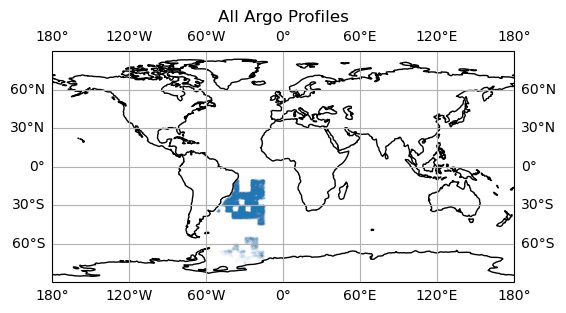

In [25]:
fig=plt.figure(figsize=(15,3))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ax.scatter(ds.LONGITUDE,ds.LATITUDE,transform=ccrs.PlateCarree(),color='tab:blue',s=0.0001)
ax.set_title('All Argo Profiles');